In [1]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm

### Run Commot

In [2]:
adata = sc.read_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')
adata

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

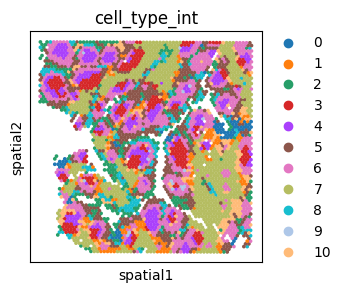

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sc.pl.embedding(adata, 'spatial', color='cell_type_int')

In [4]:
# adata.X = adata.layers['imputed_count']
adata.X = adata.layers['normalized_count']

In [5]:
df_ligrec = ct.pp.ligand_receptor_database(
    database='CellChat', 
    species='human', 
    signaling_type=None
)
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

df_ligrec['name'] = df_ligrec['ligand'] + '-' + df_ligrec['receptor']
len(df_ligrec['name'].unique())

1938

In [6]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.network import expand_paired_interactions

expanded = expand_paired_interactions(df_ligrec)
genes = set(expanded.ligand) | set(expanded.receptor)
genes = list(genes)

expanded

,ligand,receptor,pathway,signaling,name
0,TGFB1,TGFBR1,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
0,TGFB1,TGFBR2,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
1,TGFB2,TGFBR1,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
1,TGFB2,TGFBR2,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
2,TGFB3,TGFBR1,TGFb,Secreted Signaling,TGFB3-TGFBR1_TGFBR2
...,...,...,...,...,...
1936,ITGA9,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1936,ITGB1,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1937,ITGA4,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1
1937,ITGB7,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1


In [7]:
expanded = expanded[expanded.ligand.isin(adata.var_names) & expanded.receptor.isin(adata.var_names)]
expanded

,ligand,receptor,pathway,signaling,name
0,TGFB1,TGFBR1,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
0,TGFB1,TGFBR2,TGFb,Secreted Signaling,TGFB1-TGFBR1_TGFBR2
1,TGFB2,TGFBR1,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
1,TGFB2,TGFBR2,TGFb,Secreted Signaling,TGFB2-TGFBR1_TGFBR2
2,TGFB3,TGFBR1,TGFb,Secreted Signaling,TGFB3-TGFBR1_TGFBR2
...,...,...,...,...,...
1936,ITGA9,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1936,ITGB1,VCAM1,VCAM,Cell-Cell Contact,ITGA9_ITGB1-VCAM1
1937,ITGA4,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1
1937,ITGB7,VCAM1,VCAM,Cell-Cell Contact,ITGA4_ITGB7-VCAM1


In [8]:
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)

In [9]:
from spaceoracle.tools.utils import scale_adata

scale_adata(adata)

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'cell_type_int_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

In [10]:
ct.tl.spatial_communication(adata,
    database_name='user_database', 
    # df_ligrec=df_ligrec, 
    df_ligrec=expanded, 
    dis_thr=350, 
    # heteromeric=True
    heteromeric=False
)

: 

In [ ]:
adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')

In [ ]:
# lr_info = {k.replace('commot-user_database-', ''): v for k, v in adata.obsp.items() if 'commot-user_database-' in k}
# len(lr_info)

In [ ]:
# df_ligrec = df_ligrec[df_ligrec['name'].isin(lr_info.keys())]
# df_ligrec['signaling'].value_counts()

### Get cluster communication scores

In [ ]:
expanded['rename'] = expanded['ligand'] + '-' + expanded['receptor']

In [ ]:
from tqdm import tqdm
import commot as ct

for name in tqdm(expanded['rename'].unique()):

    ct.tl.cluster_communication(adata, database_name='user_database', pathway_name=name, clustering='cell_type',
        random_seed=12, n_permutations=100)

100%|██████████| 360/360 [22:09<00:00,  3.69s/it]


In [ ]:
adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')

In [ ]:
from collections import defaultdict
data_dict = defaultdict(dict)

for name in expanded['rename']:
    data_dict[name]['communication_matrix'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_matrix']
    data_dict[name]['communication_pvalue'] = adata.uns[
        f'commot_cluster-cell_type-user_database-{name}']['communication_pvalue']

import pickle
with open('/Volumes/SSD/training_data/commot_human_tonsil_proteomics_communication.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [ ]:
# check outputs

import pickle
with open('/Volumes/SSD/training_data/commot_human_tonsil_proteomics_communication.pkl', 'rb') as f:
    info = pickle.load(f)

len(info.keys())

360

In [ ]:
def get_sig_interactions(value_matrix, p_matrix, pval=0.3):
    p_matrix = np.where(p_matrix < pval, 1, 0)
    return value_matrix * p_matrix

interactions = {}

for lig, rec in tqdm(zip(expanded['ligand'], expanded['receptor']), total=len(expanded)):
    name = lig + '-' + rec

    if name in info.keys():

        value_matrix = info[name]['communication_matrix']
        p_matrix = info[name]['communication_pvalue']

        sig_matrix = get_sig_interactions(value_matrix, p_matrix)
        
        if sig_matrix.sum().sum() > 0:
            interactions[name] = sig_matrix
    
len(interactions)

100%|██████████| 430/430 [00:00<00:00, 6423.38it/s]


360

### Get expanded LR masks

In [ ]:
# create cell x gene matrix
ct_masks = {ct: adata.obs['cell_type'] == ct for ct in adata.obs['cell_type'].unique()}

df = pd.DataFrame(index=adata.obs_names, columns=genes)
df = df.fillna(0)

for name in tqdm(interactions.keys(), total=len(interactions)):
    lig, rec = name.rsplit('-', 1)
    
    tmp = interactions[name].sum(axis=1)
    for ct, val in zip(interactions[name].index, tmp):
        df.loc[ct_masks[ct], lig] += tmp[ct]
    
    tmp = interactions[name].sum(axis=0)
    for ct, val in zip(interactions[name].columns, tmp):
        df.loc[ct_masks[ct], rec] += tmp[ct]

df.shape

100%|██████████| 360/360 [00:05<00:00, 64.86it/s]


(4194, 958)

In [ ]:
print('Number of LR filtered using celltype specificity:')
np.where(df > 0, 1, 0).sum().sum() / (df.shape[0] * df.shape[1])

Number of LR filtered using celltype specificity:


0.18625922507847475

In [ ]:
df.loc[:, df.mean() > 0].shape

(4194, 208)

In [ ]:
df.to_parquet('/Volumes/SSD/training_data/human_tonsil_proteomics_LRs.parquet')

In [ ]:
df.columns[np.where(df.sum() > 0)]

Index(['PLXND1', 'DSG1', 'F11R', 'VWF', 'ITGA1', 'PPBP', 'NPNT', 'PRSS3',
       'CCL14', 'AXL',
       ...
       'CTSG', 'ITGA7', 'TNFSF13B', 'LAMB1', 'FPR2', 'IL2RB', 'TNFRSF13C',
       'SELL', 'NCAM1', 'VEGFD'],
      dtype='object', length=208)

### Cache params in adata

In [ ]:
adata

AnnData object with n_obs × n_vars = 4194 × 3000
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-WNT10A-FZD4', 'commot_cluster-cell_type-user_database-WNT10B-FZD4', 'commot_cluster-cell_type-user_database-WNT3-FZD4', 'commot_cluster-cell_type-user_database-WNT10A-LRP6', 'commot_cluster-cell_type-user_database-WNT10B-LRP6', 'commot_cluster-cell_type-user_database-WNT3-LRP6', 'commot_cluster-cell_type-user_database-TGFA-EGFR', 'commot_cluster-cell_type-user_database-TGFA-ERBB2', 'commot_cluster-cell_type-user_database-EREG-EGFR', 'commot_cluster-cell_type-user_database-EREG-ERBB2', 'commot_cluster-cell_type-user_database-FGF1-FGFR3', 'commot_cluster-cell_type-user_database-FGF18-FGFR3', 'commot_cluster-cell_type-user_database-PDGFA-PDGFRA', 'commo

In [ ]:
from spaceoracle.models.parallel_estimators import *

cell_threshes = pd.read_parquet('/Volumes/SSD/training_data/human_tonsil_proteomics_LRs.parquet')
adata.uns['cell_thresholds'] = cell_threshes
adata

AnnData object with n_obs × n_vars = 4194 × 3000
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-WNT10A-FZD4', 'commot_cluster-cell_type-user_database-WNT10B-FZD4', 'commot_cluster-cell_type-user_database-WNT3-FZD4', 'commot_cluster-cell_type-user_database-WNT10A-LRP6', 'commot_cluster-cell_type-user_database-WNT10B-LRP6', 'commot_cluster-cell_type-user_database-WNT3-LRP6', 'commot_cluster-cell_type-user_database-TGFA-EGFR', 'commot_cluster-cell_type-user_database-TGFA-ERBB2', 'commot_cluster-cell_type-user_database-EREG-EGFR', 'commot_cluster-cell_type-user_database-EREG-ERBB2', 'commot_cluster-cell_type-user_database-FGF1-FGFR3', 'commot_cluster-cell_type-user_database-FGF18-FGFR3', 'commot_cluster-cell_type-user_database-PDGFA-PDGFRA', 'commo

In [ ]:
adata = init_received_ligands(
    adata, 
    radius=350, 
    contact_distance=50, 
    cell_threshes=cell_threshes
)
adata

AnnData object with n_obs × n_vars = 4194 × 3000
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'commot-user_database-info', 'commot_cluster-cell_type-user_database-WNT10A-FZD4', 'commot_cluster-cell_type-user_database-WNT10B-FZD4', 'commot_cluster-cell_type-user_database-WNT3-FZD4', 'commot_cluster-cell_type-user_database-WNT10A-LRP6', 'commot_cluster-cell_type-user_database-WNT10B-LRP6', 'commot_cluster-cell_type-user_database-WNT3-LRP6', 'commot_cluster-cell_type-user_database-TGFA-EGFR', 'commot_cluster-cell_type-user_database-TGFA-ERBB2', 'commot_cluster-cell_type-user_database-EREG-EGFR', 'commot_cluster-cell_type-user_database-EREG-ERBB2', 'commot_cluster-cell_type-user_database-FGF1-FGFR3', 'commot_cluster-cell_type-user_database-FGF18-FGFR3', 'commot_cluster-cell_type-user_database-PDGFA-PDGFRA', 'commo

In [ ]:
# del adata.layers['imputed_count_v0']
# del adata.obsp
keys = list(adata.obsm.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsm[key]

In [ ]:
keys = list(adata.uns.keys())
for key in keys:
    if 'commot' in key:
        del adata.uns[key]

In [ ]:
keys = list(adata.obsp.keys())
for key in keys:
    if 'commot' in key:
        del adata.obsp[key]

In [ ]:
adata

AnnData object with n_obs × n_vars = 4194 × 3000
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap', 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')